In [1]:
using ReproductionNumbers, DataFrames, ExcelFiles, Plots, CSV, Statistics

In [2]:
case_name   =   "confirmed-cases"
file_name   =   "../data/20200511_Nowcasting_Zahlen.xlsx"
sheet_name  =   "Nowcast_R"
days_col    =   "Datum RKI-Tagesbericht"
data_col    =   "N_{BF} [k+3,k+4]"

case_name   =   "estimated-cases-20200511"
file_name   =   "data/20200511_Nowcasting_Zahlen.xlsx"
sheet_name  =   "Nowcast_R"
days_col    =   "Erkrankungsdatum"
data_col    =   "N(RKI-H)"

"N(RKI-H)"

In [3]:
function get_data(df::DataFrame; days_col::String, data_col::String, kind::String)
    @assert kind ∈ ( "R", "cases" ) "kind $kind not supported"
    index = df[!, days_col]
    data = df[!, data_col]
    inds = .!ismissing.(data)

    DataFrame( Dict("days" => Vector(index[inds]), "$(kind)" => Vector(data[inds]) ) )
end
function build_R_acausal_new(df::DataFrame; past::Int, future::Int, k_gen::Int)
    df_N_temp, df_R = build_R(df, past = past, future = future, k_gen = k_gen)
    df_N_acausal = compute_cases_acausal_new(df, df_R, past = past, future = future, k_gen = k_gen)
    relevant_days = df_N_acausal.days .- k_gen

    num = df_N_acausal.cases
    den = df_N_temp[ first(relevant_days) .<= df_N_temp.days .<= last(relevant_days), :cases]
    R = compute_R(num, den)

    df_N_acausal, DataFrame(days = df_N_acausal.days, R = R)
end

function compute_cases_acausal_new(df_cases::DataFrame, df_reproduction::DataFrame; past::Int, future::Int, k_gen::Int)
    start_date = first(df_reproduction).days - past
    end_date = last(df_reproduction).days + future

    @assert start_date ∈ df_cases.days "missing case numbers from the past (required start date: $(start_date))"
    @assert end_date ∈ df_cases.days "missing case numbers from the future (required end date: $(end_date))"

    N = Vector{Float64}()
    for row in eachrow(df_reproduction)
        day, R = row.days, row.R

        w = get_weights(R, past, future, k_gen)
        cases = get_values_new(df_cases, day, past, future, column = :cases)

        push!(N, mean(cases .* w))
    end

    DataFrame(days = df_reproduction.days .+ past, cases = N)
end

function get_values_new(df::DataFrame, present, past::Int, future::Int; column::Symbol = :cases)
    df[ present - past .<= df.days .<= present + future , column]
end

get_values_new (generic function with 1 method)

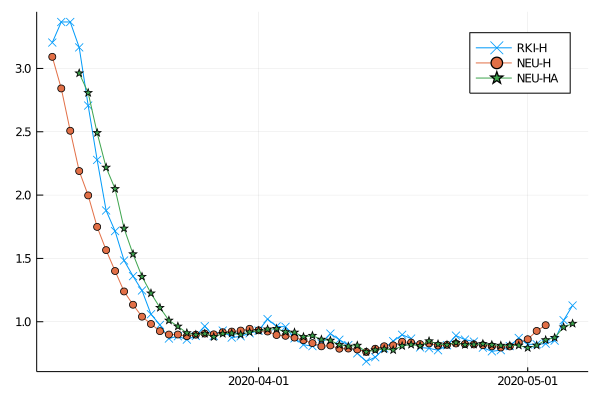

In [4]:
k_gen = 4

df = DataFrame(load(file_name, sheet_name))
df_cases = get_reference_data(df, days_col = days_col, data_col = data_col, kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)


gr()
plot(rki_h_R.days, rki_h_R.R, marker=:x, label="RKI-H")
plot!(neu_h_R.days, neu_h_R.R, marker=:c, label="NEU-H")
plot!(neu_ha_R.days, neu_ha_R.R, marker=:s, label="NEU-HA")

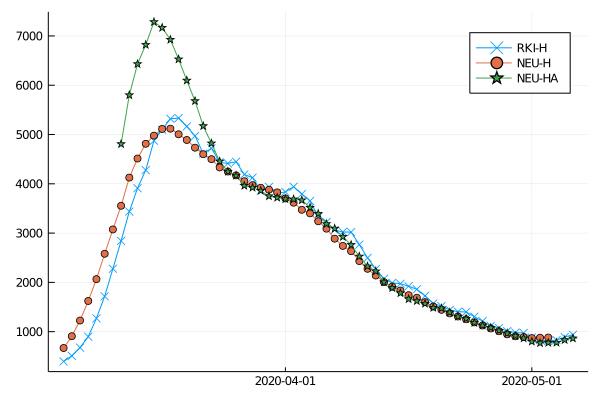

In [5]:
gr()
plot(rki_h_N.days, rki_h_N.cases, marker=:x, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, marker=:c, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, marker=:s, label="NEU-HA")

## No delay pattern

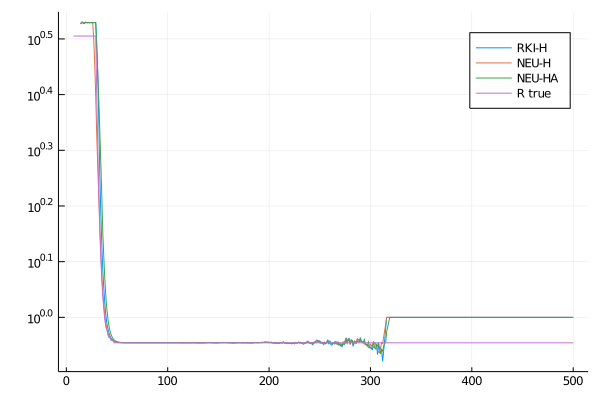

In [6]:
df = CSV.read("data/synth_0.9_day.csv")
r_true = df[!, "true R"]
index = df[!, "k"]
cases = df[!, "New cases (True)"]
df_cases = get_data(df, days_col = "k", data_col = "New cases (True)", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal_new(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)

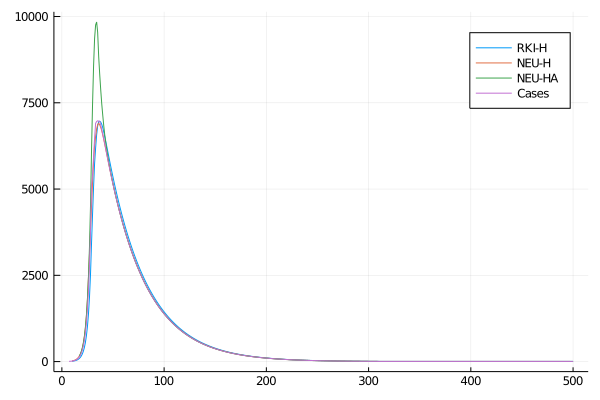

In [7]:
gr()
plot(rki_h_N.days, rki_h_N.cases, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, label="NEU-HA")
plot!(index, cases, label="Cases")

## Delayed by 10

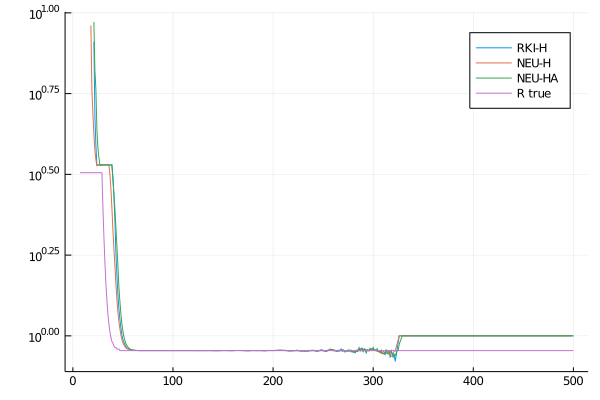

In [8]:
df = CSV.read("data/synth_0.9_day.csv")
df_cases = get_data(df, days_col = "k", data_col = "reported cases", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal_new(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)

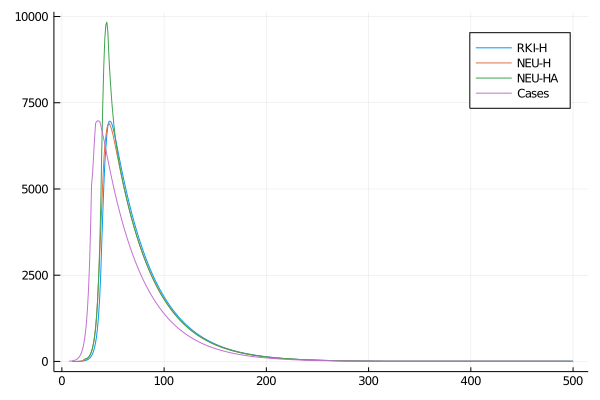

In [9]:
gr()
plot(rki_h_N.days, rki_h_N.cases, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, label="NEU-HA")
plot!(index, cases, label="Cases")

## 1 Day delay pattern

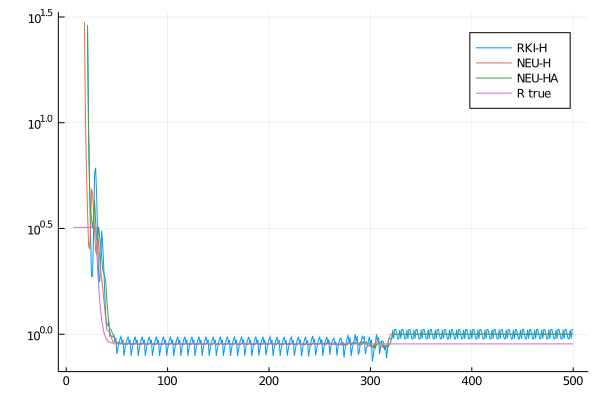

In [10]:
df = CSV.read("data/synth_0.9_day.csv")
df_cases = get_data(df, days_col = "k", data_col = "delayed", kind = "cases")
rki_h_N, rki_h_R = build_R(df_cases; past = k_gen - 1, future = 0, k_gen = k_gen)
neu_h_N, neu_h_R = build_R(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
neu_ha_N, neu_ha_R = build_R_acausal_new(df_cases; past = k_gen - 1, future = 3, k_gen = k_gen)
gr()
plot(rki_h_R.days, rki_h_R.R, label="RKI-H", yscale=:log10)
plot!(neu_h_R.days, neu_h_R.R, label="NEU-H", yscale=:log10)
plot!(neu_ha_R.days, neu_ha_R.R, label="NEU-HA", yscale=:log10)
plot!(index, r_true, label="R true", yscale=:log10)


┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots C:\Users\bened\.julia\packages\Plots\lIZ4V\src\args.jl:1179
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots C:\Users\bened\.julia\packages\Plots\lIZ4V\src\args.jl:1179
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots C:\Users\bened\.julia\packages\Plots\lIZ4V\src\args.jl:1179
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots C:\Users\bened\.julia\packages\Plots\lIZ4V\src\args.jl:1179


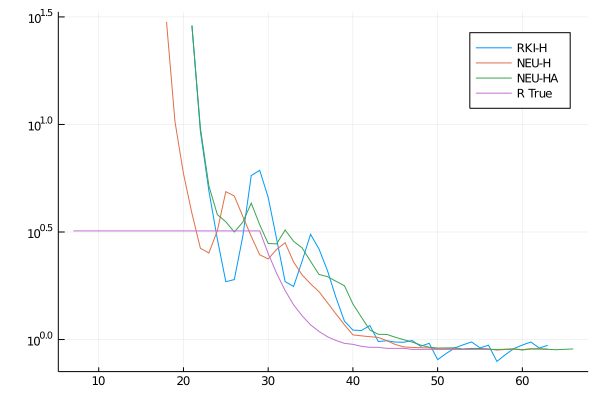

In [11]:
gr()
plot(rki_h_R.days[1:50], rki_h_R.R[1:50], label="RKI-H",yscale=:log)
plot!(neu_h_R.days[1:50], neu_h_R.R[1:50], label="NEU-H",yscale=:log)
plot!(neu_ha_R.days[1:50], neu_ha_R.R[1:50], label="NEU-HA",yscale=:log)
plot!(index[1:50], r_true[1:50], label="R True",yscale=:log)

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots C:\Users\bened\.julia\packages\Plots\lIZ4V\src\args.jl:1179


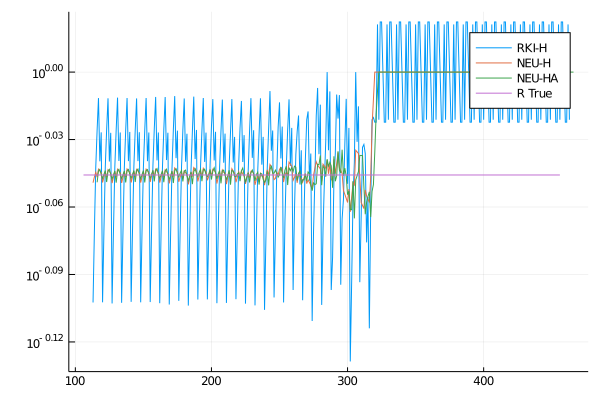

In [12]:
gr()
plot(rki_h_R.days[100:450], rki_h_R.R[100:450], label="RKI-H")
plot!(neu_h_R.days[100:450], neu_h_R.R[100:450], label="NEU-H")
plot!(neu_ha_R.days[100:450], neu_ha_R.R[100:450], label="NEU-HA")
plot!(index[100:450], r_true[100:450], label="R True",yscale=:log)

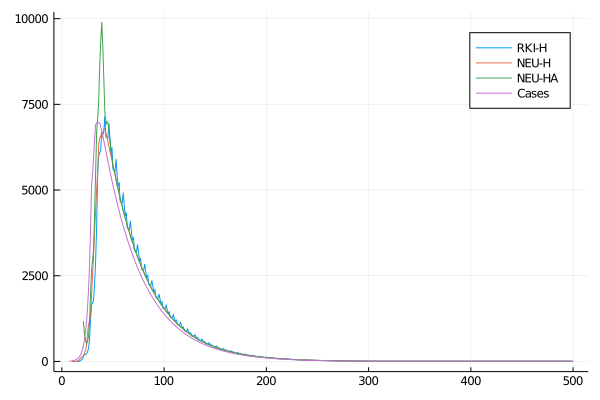

In [13]:
gr()
plot(rki_h_N.days, rki_h_N.cases, label="RKI-H")
plot!(neu_h_N.days, neu_h_N.cases, label="NEU-H")
plot!(neu_ha_N.days, neu_ha_N.cases, label="NEU-HA")
plot!(index, cases, label="Cases")